**UNIVERSIDADE DE SÃO PAULO**<br>
**MBA DATA SCIENCE & ANALYTICS USP/ESALQ**<br>
**SUPERVISED MACHINE LEARNING: EXERCÍCIOS ADICIONAIS**<br>
**Prof. Dr. Wilson Tarantim Junior**<br>
Aluna: Luiza Batista Laquini<br>
Turma: DSA 241<br>


*coding: utf-8*

In [ ]:
# #%% Instalando os pacotes necessários

# !pip install pandas
# !pip install numpy
# !pip install statsmodels
# !pip install matplotlib
# !pip install -U seaborn
# !pip install pingouin
# !pip install statstests
# !pip install scipy
# !pip install scikit-learn

In [1]:
#%% Importando os pacotes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from statstests.process import stepwise
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, recall_score

In [2]:
#%% Importando o banco de dados

demissao = pd.read_excel('data/recursos_humanos.xlsx')
## Fonte: adaptado de https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

demissao.head(3)

,demissao,idade,dist_residencia,satisfacao_amb,sexo,satisfacao_cargo,estado_civil,salario,hora_extra,qtd_treinamentos,anos_empresa,anos_promo
0,sim,41,1,média,feminino,muito_alta,solteiro,5993,sim,0,6,0
1,nao,49,8,alta,masculino,medio,casado,5130,não,3,10,1
2,sim,37,2,muito_alta,masculino,alta,solteiro,2090,sim,3,0,0


In [3]:
demissao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   demissao          1470 non-null   object
 1   idade             1470 non-null   int64 
 2   dist_residencia   1470 non-null   int64 
 3   satisfacao_amb    1470 non-null   object
 4   sexo              1470 non-null   object
 5   satisfacao_cargo  1470 non-null   object
 6   estado_civil      1470 non-null   object
 7   salario           1470 non-null   int64 
 8   hora_extra        1470 non-null   object
 9   qtd_treinamentos  1470 non-null   int64 
 10  anos_empresa      1470 non-null   int64 
 11  anos_promo        1470 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 137.9+ KB


In [11]:
#%% Estatísticas descritivas

# Variáveis métricas
print(demissao[['idade', 'dist_residencia', 'salario', 'qtd_treinamentos', 'anos_empresa', 'anos_promo']].describe(), '\n')

# Variáveis categóricas
print(demissao['demissao'].value_counts().sort_index(), '\n')
print(demissao['satisfacao_amb'].value_counts().sort_index(), '\n')
print(demissao['sexo'].value_counts().sort_index(), '\n')
print(demissao['satisfacao_cargo'].value_counts().sort_index(), '\n')
print(demissao['estado_civil'].value_counts().sort_index(), '\n')
print(demissao['hora_extra'].value_counts().sort_index(), '\n')

             idade  dist_residencia       salario  qtd_treinamentos  \
count  1470.000000      1470.000000   1470.000000       1470.000000   
mean     36.923810         9.192517   6502.931293          2.799320   
std       9.135373         8.106864   4707.956783          1.289271   
min      18.000000         1.000000   1009.000000          0.000000   
25%      30.000000         2.000000   2911.000000          2.000000   
50%      36.000000         7.000000   4919.000000          3.000000   
75%      43.000000        14.000000   8379.000000          3.000000   
max      60.000000        29.000000  19999.000000          6.000000   

       anos_empresa   anos_promo  
count   1470.000000  1470.000000  
mean       7.008163     2.187755  
std        6.126525     3.222430  
min        0.000000     0.000000  
25%        3.000000     0.000000  
50%        5.000000     1.000000  
75%        9.000000     3.000000  
max       40.000000    15.000000   

demissao
0    1233
1     237
Name: count, d

In [12]:
#%% Recodificando a variável dependente 'demissão'

# Codificando evento = 1; não evento = 0
demissao.loc[demissao['demissao']=='sim', 'demissao'] = 1
demissao.loc[demissao['demissao']=='nao', 'demissao'] = 0

# Transformando em variável numérica
demissao['demissao'] = demissao['demissao'].astype('int')

In [13]:
#%% Criando as n-1 dummies das variáveis explicativas categóricas

demissao_dummies = pd.get_dummies(demissao,
                                  columns=['satisfacao_amb',
                                           'sexo',
                                           'satisfacao_cargo',
                                           'estado_civil',
                                           'hora_extra'],
                                  dtype=int,
                                  drop_first=True)

In [14]:
demissao_dummies.head(3)

,demissao,idade,dist_residencia,salario,qtd_treinamentos,anos_empresa,anos_promo,satisfacao_amb_baixa,satisfacao_amb_muito_alta,satisfacao_amb_média,sexo_masculino,satisfacao_cargo_baixo,satisfacao_cargo_medio,satisfacao_cargo_muito_alta,estado_civil_divorciado,estado_civil_solteiro,hora_extra_sim
0,1,41,1,5993,0,6,0,0,0,1,0,0,0,1,0,1,1
1,0,49,8,5130,3,10,1,0,0,0,1,0,1,0,0,0,0
2,1,37,2,2090,3,0,0,0,1,0,1,0,0,0,0,1,1


In [15]:
#%% Criando o texto da fórmula

# Argumentos da função
# 1º argumento: banco de dados
# 2º argumento: variável dependente
# 3º argumento: variáveis a serem excluídas (se houver, inserir como lista)
def texto_formula(df, var_dependente, excluir_cols):
    variaveis = list(df.columns.values)
    variaveis.remove(var_dependente)
    for col in excluir_cols:
        variaveis.remove(col)
    return var_dependente + ' ~ ' + ' + '.join(variaveis)

texto_regressao = texto_formula(demissao_dummies, 'demissao', '')

In [16]:
#%% Regressão Logística Binária

# Estimando o modelo
modelo_demissao = sm.Logit.from_formula(texto_regressao,
                                        demissao_dummies).fit()

# Analisando os resultados
print(modelo_demissao.summary())

## Algumas variáveis não apresentam significância estatística ao nível de 5%

Optimization terminated successfully.
         Current function value: 0.348464
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               demissao   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1453
Method:                           MLE   Df Model:                           16
Date:                Mon, 07 Oct 2024   Pseudo R-squ.:                  0.2111
Time:                        20:22:14   Log-Likelihood:                -512.24
converged:                       True   LL-Null:                       -649.29
Covariance Type:            nonrobust   LLR p-value:                 5.738e-49
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.0577      0.456     -2.319      0.020   

In [17]:
#%% Obtendo o modelo após o procedimento de stepwise

# Carregamento da função 'stepwise' do pacote 'statstests.process'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

modelo_stepwise = stepwise(modelo_demissao, pvalue_limit=0.05)

Regression type: Logit 

Estimating model...: 
 demissao ~ Q('idade') + Q('dist_residencia') + Q('salario') + Q('qtd_treinamentos') + Q('anos_empresa') + Q('anos_promo') + Q('satisfacao_amb_baixa') + Q('satisfacao_amb_muito_alta') + Q('satisfacao_amb_média') + Q('sexo_masculino') + Q('satisfacao_cargo_baixo') + Q('satisfacao_cargo_medio') + Q('satisfacao_cargo_muito_alta') + Q('estado_civil_divorciado') + Q('estado_civil_solteiro') + Q('hora_extra_sim')
Optimization terminated successfully.
         Current function value: 0.348464
         Iterations 7

 Discarding atribute "Q('satisfacao_cargo_medio')" with p-value equal to 0.732987664687625 

Estimating model...: 
 demissao ~ Q('idade') + Q('dist_residencia') + Q('salario') + Q('qtd_treinamentos') + Q('anos_empresa') + Q('anos_promo') + Q('satisfacao_amb_baixa') + Q('satisfacao_amb_muito_alta') + Q('satisfacao_amb_média') + Q('sexo_masculino') + Q('satisfacao_cargo_baixo') + Q('satisfacao_cargo_muito_alta') + Q('estado_civil_divorci

In [18]:
#%% Armazenando os valores previstos para amostra

demissao_dummies['previsto'] = modelo_stepwise.predict()

## Refere-se à probabilidade de ocorrência do evento (demissão = 1)

In [20]:
demissao_dummies.head(3)

,demissao,idade,dist_residencia,salario,qtd_treinamentos,anos_empresa,anos_promo,satisfacao_amb_baixa,satisfacao_amb_muito_alta,satisfacao_amb_média,sexo_masculino,satisfacao_cargo_baixo,satisfacao_cargo_medio,satisfacao_cargo_muito_alta,estado_civil_divorciado,estado_civil_solteiro,hora_extra_sim,previsto
0,1,41,1,5993,0,6,0,0,0,1,0,0,0,1,0,1,1,0.223950
1,0,49,8,5130,3,10,1,0,0,0,1,0,1,0,0,0,0,0.020911
2,1,37,2,2090,3,0,0,0,1,0,1,0,0,0,0,1,1,0.502479


In [ ]:
#%% Matriz de confusão (definição da função)

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True (Observado)')
    plt.ylabel('Classified (Predito Modelo)')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    #Visualizando os principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

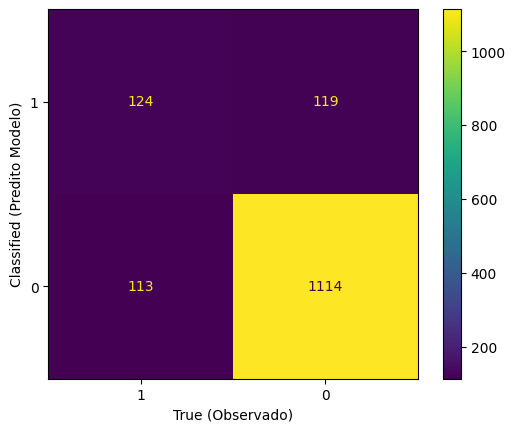

,Sensitividade,Especificidade,Acurácia
0,0.523207,0.903487,0.842177


In [21]:
#%% Matriz de confusão 

# Cutoff = 0.30
matriz_confusao(observado=demissao_dummies['demissao'],
                predicts=demissao_dummies['previsto'], 
                cutoff=0.30)

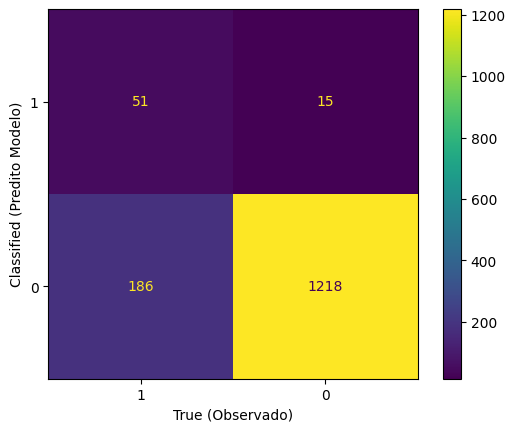

,Sensitividade,Especificidade,Acurácia
0,0.21519,0.987835,0.863265


In [33]:
# Cutoff = 0.35
matriz_confusao(observado=demissao_dummies['demissao'],
                predicts=demissao_dummies['previsto'], 
                cutoff=0.54)

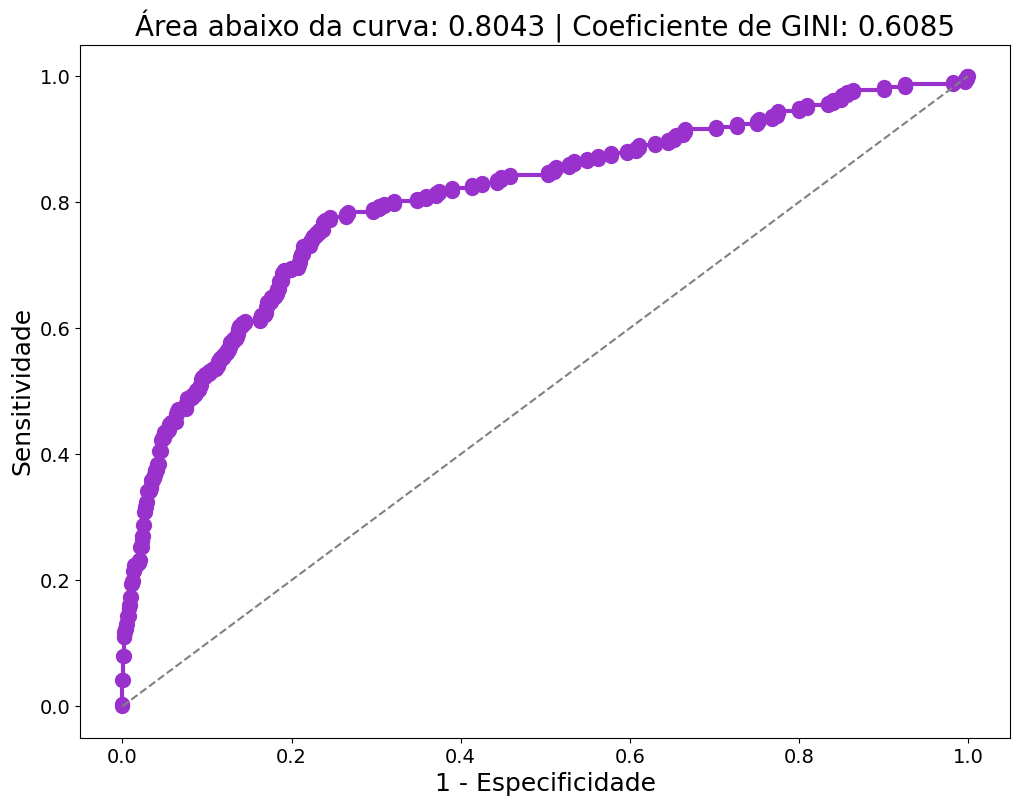

In [26]:
# A avaliação por meio da matriz de confusão depende do cutoff escolhido

#%% Análise da curva ROC

# Parametrizando a função da curva ROC (real vs. previsto)
fpr, tpr, thresholds = roc_curve(demissao_dummies['demissao'], demissao_dummies['previsto'])
roc_auc = auc(fpr, tpr)

# Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC
plt.figure(figsize=(12,9))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=20)
plt.xlabel('1 - Especificidade', fontsize=18)
plt.ylabel('Sensitividade', fontsize=18)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

In [34]:
#%% Realizando predições

# Qual é a probabilidade média esperada de um funcionário  
# com as seguintes características pedir demissão?

prob_pred = modelo_stepwise.predict(pd.DataFrame({'satisfacao_amb_baixa':[1],
                                                  'satisfacao_cargo_baixo': [0],
                                                  'satisfacao_cargo_muito_alta': [1],
                                                  'estado_civil_solteiro': [0],
                                                  'hora_extra_sim': [0],
                                                  'idade': [30],
                                                  'dist_residencia': [5],
                                                  'salario': [3000],
                                                  'qtd_treinamentos': [2],
                                                  'anos_empresa': [6],
                                                  'anos_promo': [2]}))

# O resultado mostra a probabilidade média estimada de ocorrência do evento
print(f"Probabilidade Predita: {round(prob_pred[0]*100, 2)}%")

Probabilidade Predita: 11.6%


In [35]:
#%% Analisando a odds ratio das variáveis explicativas

# Coeficientes betas estimados pelo modelo stepwise
modelo_stepwise.params[1:]

Q('idade')                         -0.032238
Q('dist_residencia')                0.032280
Q('salario')                       -0.000091
Q('qtd_treinamentos')              -0.131297
Q('anos_empresa')                  -0.089140
Q('anos_promo')                     0.142538
Q('satisfacao_amb_baixa')           1.070435
Q('satisfacao_cargo_baixo')         0.495070
Q('satisfacao_cargo_muito_alta')   -0.595085
Q('estado_civil_solteiro')          1.019344
Q('hora_extra_sim')                 1.618016
dtype: float64

In [37]:
###############################################################################

# Exemplo: odds ratio da variável 'estado_civil_solteiro'
print(np.exp(1.019344))

# Em média, mantidas as demais condições constates (ceteris paribus), a chance 
# de um funcionário pedir demissão é multiplicada por um fator de 2.77 ao ser 
# solteiro ao invés de ser casado ou divorciado

# Portanto, em média, a chance é 177% maior

# Para detalhar o resultado, note que a chance = p / (1 - p)

# Não solteiro (portanto, ser casado ou divorciado)
print(0.116 / (1 - 0.116))

# Solteiro (realizar o predict para solteiro = 1 sem alterar outros)
print(0.2667 / (1 - 0.2667))

###############################################################################

2.771376144771451
0.13122171945701358
0.36369834992499656


In [38]:
###############################################################################

# Exemplo: odds ratio da variável 'qtd_treinamentos'
print(np.exp(-0.131297))

# Em média, mantidas as demais condições constates (ceteris paribus), a chance 
# de um funcionário pedir demissão é multiplicada por um fator de 0.8769 ao 
# receber 1 treinamento a mais

# Portanto, em média, a chance é 12,31% menor

# Para detalhar o resultado, note que a chance = p / (1 - p)

# qtd_treinamentos = 2
print(0.116 / (1 - 0.116))

# qtd_treinamentos = 3 (realizar o novo predict sem alterar outros)
print(0.1032 / (1 - 0.1032))

#%% Fim!

0.8769572793974708
0.13122171945701358
0.11507582515611062
